In [162]:
%load_ext autoreload
%autoreload 2
%run Functions.py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [163]:
%pylab inline
import bq
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [130]:
import seaborn as s
from matplotlib.colors import LogNorm
s.set(rc={'image.cmap': "jet"})
figsize(12,10)
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['savefig.facecolor'] = (1,1,1,1)
rcParams['savefig.dpi'] = 100

In [132]:
# Masses
mp = 0.9382
md = 1.8756 

In [272]:
def plot_matrix(frame, xInf=None,yInf=None,xSup=None,ySup=None, **args):
    from matplotlib.colors import LogNorm
    x,y = np.meshgrid(np.array(frame.index,   dtype=float),
                      np.array(frame.columns, dtype=float))
    z = frame.T.values.astype(float)
    ret = gca().pcolor(y,x,z, **args)
    if xInf is None:
        xInf=frame.columns[0]
    if xSup is None:
        xSup=frame.columns[-1]
    if yInf is None:
        yInf=frame.index[0]
    if ySup is None:
        ySup=frame.index[-1]
        
    
    xlim(xInf,xSup)
    ylim(yInf,ySup)
    
    return ret

In [133]:
client = bq.Client.Get()

In [134]:
from histQueryFactory import *

In [135]:
schema = client.GetTableSchema({
    'projectId': 'ams-test-kostya', 
    'datasetId': 'AMS',  
    'tableId': 'protonsB1034'
})

bitFields = None
for field in schema['fields']:
    if field['name'] != 'selStatus': 
        continue
    bitFields = field['description'].split(',')
    break
    
get_cumulative_mask = lambda sel: (1 << (bitFields.index(sel))) - 1

In [136]:
def build_frames(frames, table):
    for v in[ ("1/R",0,2,100, "invR"),
              ("EdepTRD",0,200,200, "EdepTRD"), 
              ("EdepTOF_0+EdepTOF_1+EdepTOF_2+EdepTOF_3",0,40,100, "EdepTOF"),
              ("(EdepTOF_0+EdepTOF_1+EdepTOF_2+EdepTOF_3)/NTofClusters",0,20,200, "EdepTOFPerCluster"),
              ("EdepTrack",0,1000,100, "EdepTrack") 
            ]:
        h = HistQueryFactory(table=table)
        h.add_variable(*v)
        h.add_variable("1/BetaTOF",0.5,2.0,100, 'ib')

        #h.add_condition("selStatus&{0}={0}".format(get_cumulative_mask('aRing')))
        h.add_condition("unusedLayers==0")

        tableid = client.Query(str(h))['configuration']['query']['destinationTable']
        bq_table = client.ReadTableRows(tableid)

        frames[v[-1]] = pd.DataFrame(bq_table, columns=h.get_variables()+['Counts']).astype(float)

def plot_frames(frames):
    from matplotlib.colors import LogNorm
    s.set(rc={'image.cmap': "jet"})
    for n, k in enumerate(frames):
        subplot(2,2,n+1,)
        frame = frames[k]
        frame = frame.set_index(list(frame.columns[:-1])).unstack().fillna(0)['Counts']
        frame /= frame.sum(axis=0)
        plot_matrix(frame, norm=LogNorm(vmin=10**(-5),vmax=1))
        xlabel("1/BetaTOF")
        ylabel(k)

In [137]:
framesMC, framesData = {}, {}
build_frames(framesMC,   "AMS.protonsB1034")
build_frames(framesData, "AMS.Data")

Waiting on bqjob_r5906203ce5cf1a98_0000014f5fde27ec_49 ... (0s) Current status: DONE   
Waiting on bqjob_rfc330f3591ac556_0000014f5fde32f8_50 ... (0s) Current status: DONE   
Waiting on bqjob_r67e55e17d62b9de7_0000014f5fde3f47_51 ... (0s) Current status: DONE   
Waiting on bqjob_r412b86613a8b4f91_0000014f5fde4992_52 ... (0s) Current status: DONE   
Waiting on bqjob_r3138b4827e4bd23f_0000014f5fde5652_53 ... (0s) Current status: DONE   
Waiting on bqjob_r7c0d8c3dfcbd43db_0000014f5fde60d9_54 ... (0s) Current status: DONE   
Waiting on bqjob_r379dc23a8b5da148_0000014f5fde6c87_55 ... (0s) Current status: DONE   
Waiting on bqjob_r140e9d96c969a50b_0000014f5fde7a45_56 ... (0s) Current status: DONE   
Waiting on bqjob_r1150b073cab53e88_0000014f5fde854e_57 ... (0s) Current status: DONE   
Waiting on bqjob_r405d171700ebf626_0000014f5fde925d_58 ... (0s) Current status: DONE   


ValueError: num must be 0 <= num <= 4, not 5

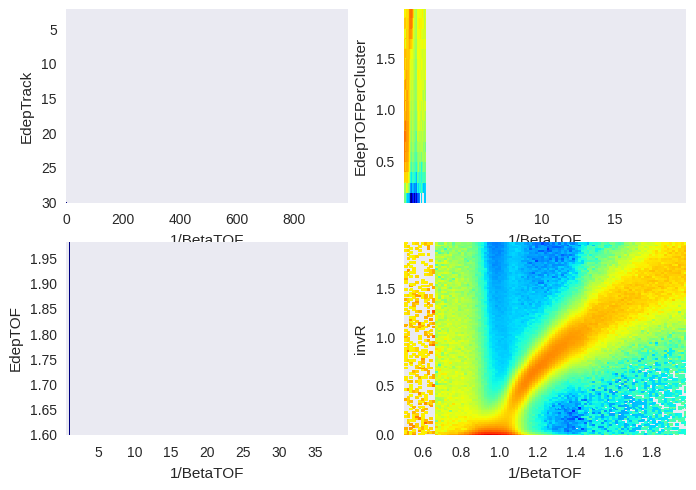

In [138]:
figsize(24,8)
plot_frames(framesMC)
tight_layout()

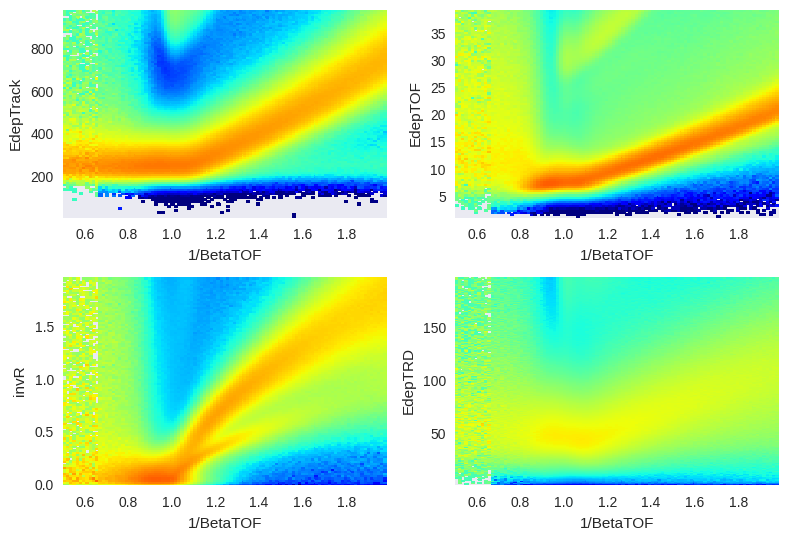

In [17]:
figsize(12,8)
plot_frames(framesData)
tight_layout()

In [22]:
frames = {}
for v in[
    ("1/R",0,2,100, "invR"),
    ("EdepTRD",0,200,200, "EdepTRD"), 
    ("EdepTOF_0+EdepTOF_1+EdepTOF_2+EdepTOF_3",0,40,100, "EdepTOF"),
    ("EdepTrack",0,1000,100, "EdepTrack")
]:

    print v
    h = HistQueryFactory(table=build_frames(framesMC, "AMS.protonsB1034"))
    h.add_variable(*v)
    h.add_variable("1/BetaTOF",0.5,2.0,100, 'ib')

    #h.add_condition("selStatus&{0}={0}".format(get_cumulative_mask('aRing')))
    h.add_condition("unusedLayers==0")

    tableid = client.Query(str(h))['configuration']['query']['destinationTable']
    bq_table = client.ReadTableRows(tableid)

    frames[v[-1]] = pd.DataFrame(bq_table, columns=h.get_variables()+['Counts']).astype(float)

('1/R', 0, 2, 100, 'invR')
Waiting on bqjob_r19e133d0f9803e94_0000014f5f430a0f_24 ... (0s) Current status: DONE   
Waiting on bqjob_r29175a2dd5d44cb5_0000014f5f431474_25 ... (0s) Current status: DONE   
Waiting on bqjob_r53eddd1643e54142_0000014f5f432106_26 ... (0s) Current status: DONE   
Waiting on bqjob_r1d8f5f1c83a82e8b_0000014f5f432c61_27 ... (0s) Current status: DONE   


BigqueryServiceError: Error processing job 'ams-test-kostya:bqjob_r4971530766cc13a2_0000014f5f43372c_28': Table name cannot be resolved: dataset name is missing.

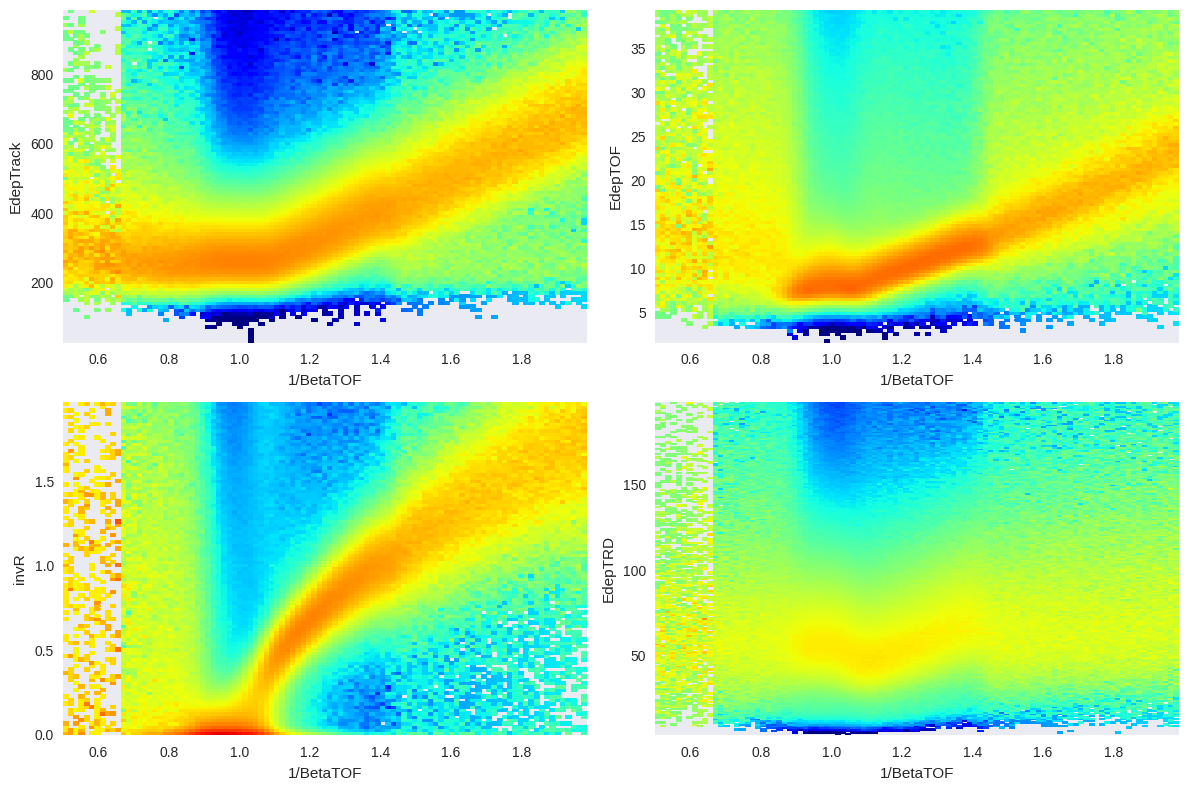

In [24]:
from matplotlib.colors import LogNorm
s.set(rc={'image.cmap': "jet"})
figsize(12,8)

for n, k in enumerate(framesMC):
    subplot(2,2,n+1,)
    frame = framesMC[k]
    frame = frame.set_index(list(frame.columns[:-1])).unstack().fillna(0)['Counts']
    frame /= frame.sum(axis=0)
    plot_matrix(frame, norm=LogNorm(vmin=10**(-5),vmax=1))
    xlabel("1/BetaTOF")
    ylabel(k)
    
tight_layout()

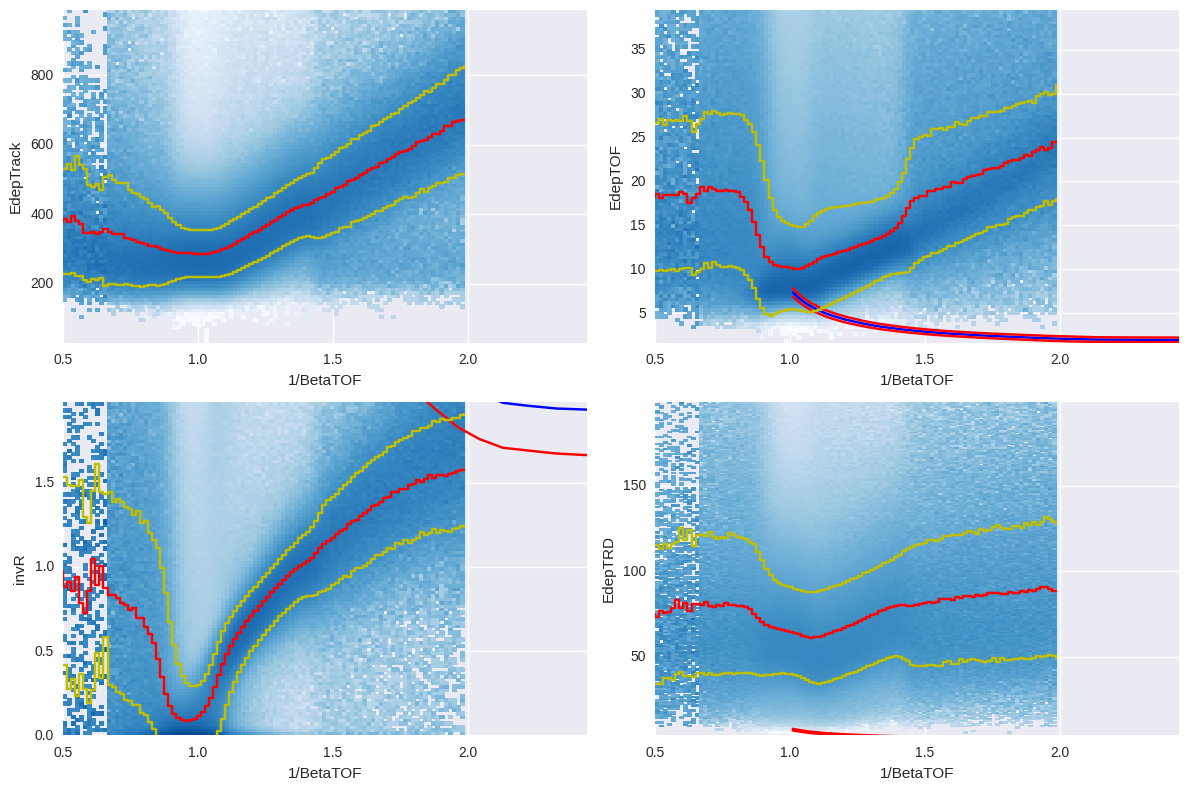

In [44]:
from matplotlib.colors import LogNorm
s.set(rc={'image.cmap': "Blues"})
figsize(12,8)

for n, k in enumerate(framesMC):
    subplot(2,2,n+1,)
    frame = framesMC[k]
    frame = frame.set_index(list(frame.columns[:-1])).unstack().fillna(0)['Counts']
    frame /= frame.sum(axis=0)
    plot_matrix(frame, norm=LogNorm(vmin=10**(-5),vmax=1))
    
    invBetaCent=1/Beta_cent[::-1]
    plot(invBetaCent,ETOF,'b')
    plot(invBetaCent,ETOF+sigmaEtofinv*(ETOF**2),'r')
    plot(invBetaCent,ETOF-sigmaEtofinv*(ETOF**2),'r')
    
    mean = frame.mul(pd.Series(frame.index,frame.index), axis=0).sum(axis=0)
    std = frame.mul((pd.Series(frame.index,frame.index))**2, axis=0).sum(axis=0)
    std = np.sqrt((std-mean**2))
    
       
    mean.plot(style='r', drawstyle='steps')   
    (mean+std).plot(style='y', drawstyle='steps-post')
    (mean-std).plot(style='y', drawstyle='steps-post')
    
    xlabel("1/BetaTOF")
    ylabel(k)
    
tight_layout()

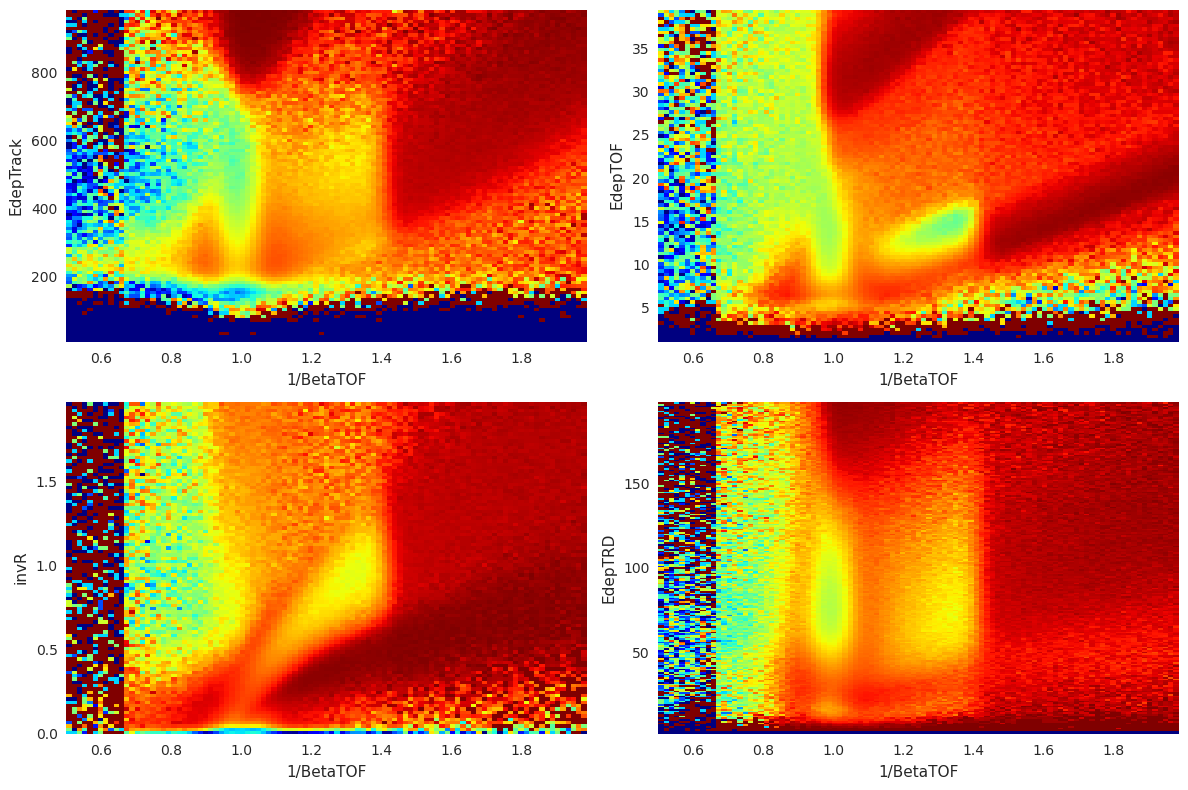

In [42]:
from matplotlib.colors import LogNorm
s.set(rc={'image.cmap': "jet"})
figsize(12,8)

for n, k in enumerate(frames):
    subplot(2,2,n+1,)
    frame = frames[k]
    frame = frame.set_index(list(frame.columns[:-1])).unstack().fillna(0)['Counts']
    #frame /= frame.sum(axis=0)
    frameMC = framesMC[k]
    frameMC = frameMC.set_index(list(frameMC.columns[:-1])).unstack().fillna(0)['Counts']
    #frameMC /= frameMC.sum(axis=0)

    
    plot_matrix((np.abs(frame-frameMC)/(frame+frameMC)).fillna(0))#, norm=LogNorm(vmin=10**(-5),vmax=100))
    xlabel("1/BetaTOF")
    ylabel(k)

tight_layout()

In [309]:
from scipy.optimize import leastsq

def fitGaussianPerXSlice(frame,key):
    inverseBetaBin=np.unique(frame['ib'])

    gausParam=[]

    for bin in inverseBetaBin:
        df=frame[frame['ib']==bin]

        fitfunc  = lambda p, x: p[0]*exp(-0.5*((x-p[1])/p[2])**2)
        errfunc  = lambda p, x, y: (y - fitfunc(p, x))

        mean=np.average(df[key], weights=df.Counts)
        std=np.average((df[key]-mean)**2,weights=df.Counts)
        std=math.sqrt(std)
        init  = [df['Counts'].max(),
                 mean,
                 std]

        out   = leastsq( errfunc, init, args=(df[key], df['Counts']))
        gausParam.append(out[0])

    gausParam=np.array(gausParam[::])
    return gausParam

['EdepTOFPerCluster', 'ib']
Float64Index([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1.0, 
              ...
              19.0, 19.1, 19.2, 19.3, 19.4, 19.5, 19.6, 19.7, 19.8, 19.9],
             dtype='float64', name=u'EdepTOFPerCluster', length=199)


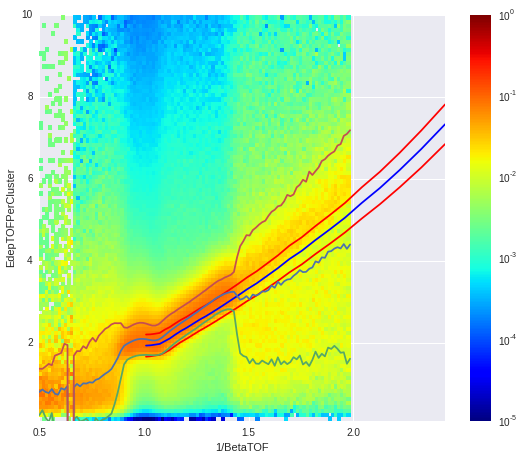

In [334]:
# s.set(rc={'image.cmap': "jet"})

frames = {key: framesMC[key] for key in framesMC if key in ['EdepTOFPerCluster'] }
figsize(20,16)



def plotFrancescoEnveloppes(xAxis,mean,sigma):
    plot(xAxis,mean,'b')
    plot(xAxis,mean+sigma*(ETOFSwapped**2),'r')
    plot(xAxis,mean-sigma*(ETOFSwapped**2),'r')
    
for n, k in enumerate(frames):
    subplot(2,2,n+1,)
    
    frame = frames[k]
    gaussian=fitGaussianPerXSlice(frame,k)
    print list(frame.columns[:-1])
    frame = frame.set_index(list(frame.columns[:-1])).unstack().fillna(0)['Counts']
    print frame.index
    frame /= frame.sum(axis=0)
    fig=plot_matrix(frame, norm=LogNorm(vmin=10**(-5),vmax=1),ySup=10)
    colorbar(fig)
    plotFrancescoEnveloppes(1/Beta_cent[::-1],ETOF[::-1], sigmaEtofinv[::-1])


    mean = pd.Series(gausParam.T[1],frame.columns.values)
    sigmaAboveMean = pd.Series(gausParam.T[1] + gausParam.T[2],frame.columns.values)
    sigmaBelowMean = pd.Series(gausParam.T[1] - gausParam.T[2],frame.columns.values)
    
    mean.plot()
    sigmaBelowMean.plot()
    sigmaAboveMean.plot()
    
    xlabel("1/BetaTOF")
    ylabel(k)
    


In [307]:
mean = pd.Series(gausParam[:,[1]].tolist(),frame.columns.values)
print mean

0.500    [0.804661761534]
0.515    [0.863420945531]
0.530    [0.803483047432]
0.545    [0.777335080616]
0.560    [0.873077400203]
0.575    [0.758298944017]
0.590    [0.737333790336]
0.605    [0.895769710356]
0.620    [0.858892036587]
0.635    [0.950430282228]
0.650    [-56.3037085963]
0.665    [0.918273182844]
0.680    [0.998839299367]
0.695    [0.940363864697]
0.710     [1.01424477569]
0.725     [1.00828173346]
0.740     [1.04013514728]
0.755     [1.03052744767]
0.770     [1.09942190609]
0.785     [1.12596116485]
0.800     [1.18972250027]
0.815     [1.24716062124]
0.830     [1.29647777375]
0.845     [1.36429599709]
0.860     [1.49433933094]
0.875      [1.6354063055]
0.890     [1.80694972943]
0.905     [1.92638966956]
0.920     [1.97797851607]
0.935     [2.01896438535]
               ...       
1.550     [3.18774785226]
1.565     [3.25720860719]
1.580     [3.25081937978]
1.595     [3.28991616485]
1.610     [3.39983524183]
1.625     [3.34496801271]
1.640     [3.49155678756]
1.655     [3

In [328]:
gausParam.T


array([[  2.73308998e+01,   2.68280654e+01,   2.55922992e+01,
          2.13844197e+01,   2.23135988e+01,   1.50994204e+01,
          1.53188617e+01,   1.28169490e+01,   9.24122505e+00,
          8.57031353e+00,   1.09887116e+05,   1.26235140e+02,
          1.34249516e+02,   1.39891555e+02,   1.45266879e+02,
          1.64814724e+02,   1.74702689e+02,   1.89991963e+02,
          2.32993388e+02,   2.60701069e+02,   2.97110559e+02,
          3.47868743e+02,   4.39735240e+02,   5.59197419e+02,
          7.51127736e+02,   1.19266458e+03,   2.19882135e+03,
          5.14195538e+03,   1.09288803e+04,   2.12142959e+04,
          3.69825097e+04,   5.74127322e+04,   7.65166120e+04,
          8.75896700e+04,   8.63625194e+04,   7.39172322e+04,
          5.67316490e+04,   3.97745242e+04,   2.73522484e+04,
          1.91828889e+04,   1.46658345e+04,   1.20221315e+04,
          1.04593161e+04,   9.46936977e+03,   8.57582948e+03,
          7.81771979e+03,   7.25543921e+03,   6.82227534e+03,
        

In [317]:
s = pd.Series([1,3,5,np.nan,6,8])
s

0     1
1     3
2     5
3   NaN
4     6
5     8
dtype: float64